# Hybrid recommendation system

<img src='../input/photo-1489599849927-2ee91cede3ba.jpeg' height="500">

Photo by [Felix Mooneeram](https://unsplash.com/@felixmooneeram)

## Origin of dataset

MovieLens data sets were collected by the GroupLens Research Project at the University of Minnesota.

This data set consists of: * 100,000 ratings (1-5) from 943 users on 1682 movies. * Each user has rated at least 20 movies. * Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site (movielens.umn.edu) during the seven-month period from September 19th, 1997 through April 22nd, 1998. This data has been cleaned up - users who had less than 20 ratings or did not have complete demographic information were removed from this data set. Detailed descriptions of the data file can be found at the end of this file.

Neither the University of Minnesota nor any of the researchers involved can guarantee the correctness of the data, its suitability for any particular purpose, or the validity of results based on the use of the data set. The data set may be used for any research purposes under the following conditions:

## Definition of a recommandation system

Credits: [Wikipedia](https://en.wikipedia.org/wiki/Recommender_system)
    
_It is a subclass of information filtering system that seeks to predict the "rating" or "preference" a user would give to an item. They are primarily used in commercial applications._

_Recommender systems are utilized in a variety of areas, and are most commonly recognized as playlist generators for video and music services like Netflix, YouTube and Spotify, product recommenders for services such as Amazon, or content recommenders for social media platforms such as Facebook and Twitter. These systems can operate using a single input, like music, or multiple inputs within and across platforms like news, books, and search queries. There are also popular recommender systems for specific topics like restaurants and online dating._

## Recommandation engine design

There are different approaches, some of them are:

__Collaborative filtering__

_It is based on the assumption that people who agreed in the past will agree in the future, and that they will like similar kinds of items as they liked in the past. The system generates recommendations using only information about rating profiles for different users or items. By locating peer users/items with a rating history similar to the current user or item, they generate recommendations using this neighborhood [...]._

_Advantage: it does not rely on machine analyzable content and therefore it is capable of accurately recommending complex items such as movies without requiring an "understanding" of the item itself [...]._

__Content-based filtering__

_It is based on a description of the item and a profile of the user’s preferences. This methods is best suited to situations where there is known data on an item (name, location, description, etc.), but not on the user. Content-based recommenders treat recommendation as a user-specific classification problem and learn a classifier for the user's likes and dislikes based on product features._

_In this system, keywords are used to describe the items and a user profile is built to indicate the type of item this user likes. This algorithms try to recommend items that are similar to those that a user liked in the past, or is examining in the present. It does not rely on a user sign-in mechanism to generate this often temporary profile. In particular, various candidate items are compared with items previously rated by the user and the best-matching items are recommended.[...]_

__Hybrid recommender systems__

_Most recommender systems now use a hybrid approach, combining collaborative filtering, content-based filtering, and other approaches._

---

# Data exploration & preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import sparse

#import numpy as np
#import scipy.sparse as sparse

## Detailed description of used data files

In [2]:
rating_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
df_ratings = pd.read_csv('../input/u.data', sep='\t', names=rating_cols)
df_ratings.shape

(100000, 4)

In [3]:
df_ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
df_users = pd.read_csv('../input/u.user', sep='|', names=users_cols, parse_dates=True)
df_users.head()

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [5]:
items_cols = ['movie_id' , 'movie_title' , 'release_date' , 'video_release_date' , 'IMDb_URL' , 'unknown|' , 'Action|' , 'Adventure|', 'Animation|', "Children's|", 'Comedy|', 'Crime|', 'Documentary|', 'Drama|',\
              'Fantasy|', 'Film-Noir|', 'Horror|', 'Musical|', 'Mystery|', 'Romance|', 'Sci-Fi|', 'Thriller|', \
              'War|', 'Western|']
df_items = pd.read_csv('../input/u.item', sep='|', encoding='latin-1', names=items_cols, parse_dates=True, index_col='movie_id')
df_items.head()

,movie_title,release_date,video_release_date,IMDb_URL,unknown|,Action|,Adventure|,Animation|,Children's|,Comedy|,...,Fantasy|,Film-Noir|,Horror|,Musical|,Mystery|,Romance|,Sci-Fi|,Thriller|,War|,Western|
movie_id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
movie_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
df_movies = pd.read_csv('../input/u.item', sep='|', names=movie_cols, usecols=range(5), encoding='latin-1', index_col='movie_id')
df_movies.shape

(1682, 4)

In [7]:
df_movies.head()

,title,release_date,video_release_date,imdb_url
movie_id,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)


df_movies provides infos for each movie (ie for each line).

df_ratings provides infos for each rating a user have made.

u.data -- The full u data set, 100000 ratings by 943 users on 1682 items. Each user has rated at least 20 movies. Users and items are numbered consecutively from 1. The data is randomly ordered. This is a tab separated list of user id | item id | rating | timestamp. The time stamps are unix seconds since 1/1/1970 UTC

u.item -- Information about the items (movies); this is a tab separated list of movie id | movie title | release date | video release date | IMDb URL | unknown | Action | Adventure | Animation | Children's | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western | The last 19 fields are the genres, a 1 indicates the movie is of that genre, a 0 indicates it is not; movies can be in several genres at once. The movie ids are the ones used in the u.data data set.



## Data Visualizations

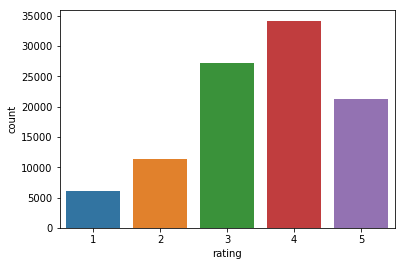

In [8]:
sns.countplot(x='rating', data=df_ratings)

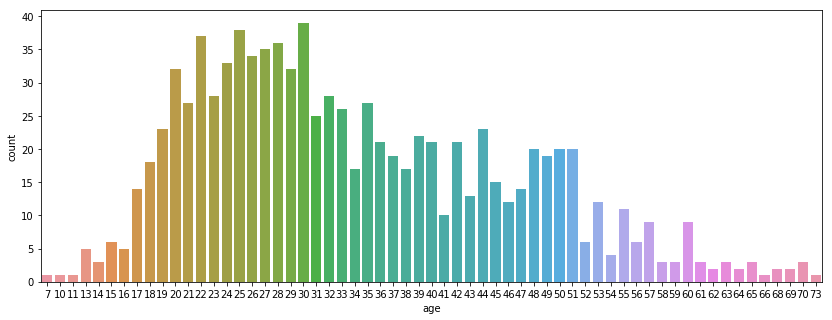

In [9]:
plt.figure(figsize=(14, 5))
sns.countplot(x='age', data=df_users)

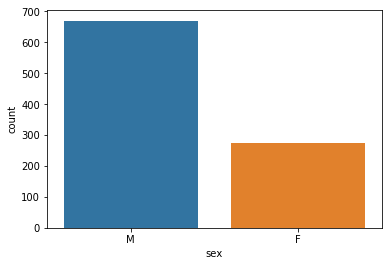

In [10]:
sns.countplot(x='sex', data=df_users)

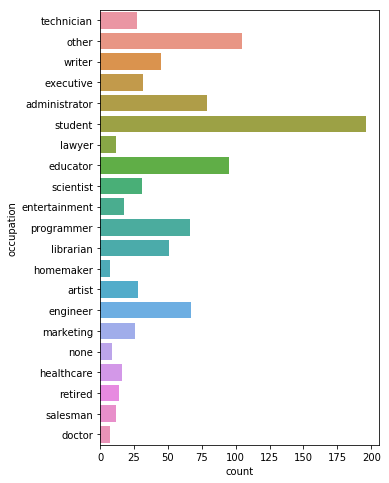

In [11]:
plt.figure(figsize=(5, 8))
sns.countplot(y='occupation', data=df_users)

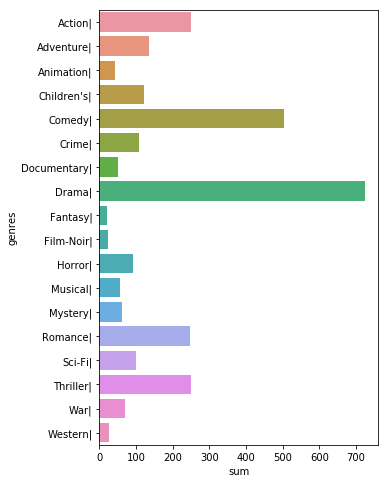

In [13]:
genre_list = ['Action|' , 'Adventure|' , 'Animation|' , "Children's|" , 'Comedy|' , 'Crime|' , 'Documentary|' , 'Drama|' \
              , 'Fantasy|' , 'Film-Noir|' , 'Horror|' , 'Musical|' , 'Mystery|' , 'Romance|' , 'Sci-Fi|' , 'Thriller|' , \
              'War|' , 'Western|']
genre_sum = []
for g in genre_list:
    genre_sum.append(df_items[g].sum())

genre_df = pd.DataFrame({'genres' : genre_list, 'sum' : genre_sum})

plt.figure(figsize=(5, 8))
sns.barplot(y='genres', x='sum', data=genre_df)

## Data preparation

In [14]:
df_items.columns

Index(['movie_title', 'release_date', 'video_release_date', 'IMDb_URL',
       'unknown|', 'Action|', 'Adventure|', 'Animation|', 'Children's|',
       'Comedy|', 'Crime|', 'Documentary|', 'Drama|', 'Fantasy|', 'Film-Noir|',
       'Horror|', 'Musical|', 'Mystery|', 'Romance|', 'Sci-Fi|', 'Thriller|',
       'War|', 'Western|'],
      dtype='object')

In [15]:
df_items = df_items.drop(columns=['movie_title', 'release_date', 'video_release_date', 'IMDb_URL'])
df_items = df_items.assign(genres=df_items.values.dot(df_items.columns.values))
df_items = df_items.drop(columns=['unknown|', 'Action|', 'Adventure|', 'Animation|', "Children's|",\
       'Comedy|', 'Crime|', 'Documentary|', 'Drama|', 'Fantasy|', 'Film-Noir|',\
       'Horror|', 'Musical|', 'Mystery|', 'Romance|', 'Sci-Fi|', 'Thriller|',\
       'War|', 'Western|'])

df_movies = pd.concat([df_movies, df_items], axis=1)
df_movies = df_movies.drop(columns=['release_date', 'video_release_date', 'imdb_url'])
df_movies.head()

,title,genres
movie_id,,
1,Toy Story (1995),Animation|Children's|Comedy|
2,GoldenEye (1995),Action|Adventure|Thriller|
3,Four Rooms (1995),Thriller|
4,Get Shorty (1995),Action|Comedy|Drama|
5,Copycat (1995),Crime|Drama|Thriller|


In [16]:
df_ratings = df_ratings.drop(columns=['unix_timestamp'])
df_ratings.head()

,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In order to fit a LightFM model, the Dataframe should be transformed to a sparse matrix (i.e a big matrice with a lot of zeros or empty values). Pandas' df & Numpy arrays are not suitable for manipulating this kind of data. We need to use Scipy sparse matrices.

By going so, the information of the ids (userId and movieId) will be lost. Then we will only deal with indices (row number and column number). Therefore, the df_to_matrix function also returns dictionaries mapping indexes to ids (ex: uid_to_idx mapping userId to index of the matrix)

In [17]:
# Reference : https://github.com/EthanRosenthal/rec-a-sketch

def threshold_interactions_df(df, row_name, col_name, row_min, col_min):
    """Limit interactions df to minimum row and column interactions.
    Parameters
    ----------
    df : DataFrame
        DataFrame which contains a single row for each interaction between
        two entities. Typically, the two entities are a user and an item.
    row_name : str
        Name of column in df which corresponds to the eventual row in the
        interactions matrix.
    col_name : str
        Name of column in df which corresponds to the eventual column in the
        interactions matrix.
    row_min : int
        Minimum number of interactions that the row entity has had with
        distinct column entities.
    col_min : int
        Minimum number of interactions that the column entity has had with
        distinct row entities.
    Returns
    -------
    df : DataFrame
        Thresholded version of the input df. Order of rows is not preserved.
    Examples
    --------
    df looks like:
    user_id | item_id
    =================
      1001  |  2002
      1001  |  2004
      1002  |  2002
    thus, row_name = 'user_id', and col_name = 'item_id'
    If we were to set row_min = 2 and col_min = 1, then the returned df would
    look like
    user_id | item_id
    =================
      1001  |  2002
      1001  |  2004
    """

    n_rows = df[row_name].unique().shape[0]
    n_cols = df[col_name].unique().shape[0]
    sparsity = float(df.shape[0]) / float(n_rows*n_cols) * 100
    print('Starting interactions info')
    print('Number of rows: {}'.format(n_rows))
    print('Number of cols: {}'.format(n_cols))
    print('Sparsity: {:4.3f}%'.format(sparsity))

    done = False
    while not done:
        starting_shape = df.shape[0]
        col_counts = df.groupby(row_name)[col_name].count()
        df = df[~df[row_name].isin(col_counts[col_counts < col_min].index.tolist())]
        row_counts = df.groupby(col_name)[row_name].count()
        df = df[~df[col_name].isin(row_counts[row_counts < row_min].index.tolist())]
        ending_shape = df.shape[0]
        if starting_shape == ending_shape:
            done = True

    n_rows = df[row_name].unique().shape[0]
    n_cols = df[col_name].unique().shape[0]
    sparsity = float(df.shape[0]) / float(n_rows*n_cols) * 100
    print('Ending interactions info')
    print('Number of rows: {}'.format(n_rows))
    print('Number of columns: {}'.format(n_cols))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    return df

def get_df_mappings(df, row_name, col_name):
    """Map entities in interactions df to row and column indices
    Parameters
    ----------
    df : DataFrame
        Interactions DataFrame.
    row_name : str
        Name of column in df which contains row entities.
    col_name : str
        Name of column in df which contains column entities.
    Returns
    -------
    rid_to_idx : dict
        Maps row ID's to the row index in the eventual interactions matrix.
    idx_to_rid : dict
        Reverse of rid_to_idx. Maps row index to row ID.
    cid_to_idx : dict
        Same as rid_to_idx but for column ID's
    idx_to_cid : dict
    """


    # Create mappings
    rid_to_idx = {}
    idx_to_rid = {}
    for (idx, rid) in enumerate(df[row_name].unique().tolist()):
        rid_to_idx[rid] = idx
        idx_to_rid[idx] = rid

    cid_to_idx = {}
    idx_to_cid = {}
    for (idx, cid) in enumerate(df[col_name].unique().tolist()):
        cid_to_idx[cid] = idx
        idx_to_cid[idx] = cid

    return rid_to_idx, idx_to_rid, cid_to_idx, idx_to_cid


def df_to_matrix(df, row_name, col_name):
    """Take interactions dataframe and convert to a sparse matrix
    Parameters
    ----------
    df : DataFrame
    row_name : str
    col_name : str
    Returns
    -------
    interactions : sparse csr matrix
    rid_to_idx : dict
    idx_to_rid : dict
    cid_to_idx : dict
    idx_to_cid : dict
    """
    rid_to_idx, idx_to_rid,\
        cid_to_idx, idx_to_cid = get_df_mappings(df, row_name, col_name)

    def map_ids(row, mapper):
        return mapper[row]

    I = df[row_name].apply(map_ids, args=[rid_to_idx]).values
    J = df[col_name].apply(map_ids, args=[cid_to_idx]).values
    V = np.ones(I.shape[0])
    interactions = sparse.coo_matrix((V, (I, J)), dtype=np.float64)
    interactions = interactions.tocsr()
    return interactions, rid_to_idx, idx_to_rid, cid_to_idx, idx_to_cid

In [18]:
ratings_matrix, user_id_to_idx, idx_to_user_id, movie_id_to_idx, idx_to_movie_id = df_to_matrix \
        (df_ratings, row_name='user_id', col_name='movie_id')

ratings_matrix.toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

This leads to the creation of 5 new variables:

* a final sparse matrix ratings_matrix (this will be the data used to train the model) and the following utils mappers:
* uid_to_idx
* idx_to_uid
* mid_to_idx
* idx_to_mid

__How to use those mappers ?__

In [19]:
# for instance what movies did the userId 4 rate¶
movies_user4 = ratings_matrix.toarray()[user_id_to_idx[4], :]
movies_id_user4 = np.sort(np.vectorize(idx_to_movie_id.get)(np.argwhere(movies_user4>0).flatten()))
df_movies.loc[movies_id_user4, :]['title']

movie_id
11                          Seven (Se7en) (1995)
50                              Star Wars (1977)
210    Indiana Jones and the Last Crusade (1989)
258                               Contact (1997)
260                         Event Horizon (1997)
264                                 Mimic (1997)
271                     Starship Troopers (1997)
288                                Scream (1996)
294                             Liar Liar (1997)
300                         Air Force One (1997)
301                              In & Out (1997)
303                           Ulee's Gold (1997)
324                          Lost Highway (1997)
327                              Cop Land (1997)
328                     Conspiracy Theory (1997)
329                    Desperate Measures (1998)
354                   Wedding Singer, The (1998)
356                           Client, The (1994)
357       One Flew Over the Cuckoo's Nest (1975)
358                                 Spawn (1997)
359        

In [20]:
# On the other side, what is the value of ratings_matrix for: userId = 4
movieId_list = [11, 50, 210, 324, 8, 9, 10]

movieId_idx = [movie_id_to_idx[i] for i in movieId_list]
movieId_idx

ratings_user4 = ratings_matrix.toarray()[user_id_to_idx[4], movieId_idx]
ratings_user4
#the values in ratings_matrix tells if a user a rated a movie but don't explicit the rating value

array([1., 1., 1., 1., 0., 0., 0.])

---

# Recommendation model

In [21]:
from lightfm.cross_validation import random_train_test_split
from lightfm import LightFM
from lightfm.evaluation import precision_at_k

## Introduction to [lightFM](https://lyst.github.io/lightfm/docs/index.html)

_LightFM is a Python implementation of a number of popular recommendation algorithms for both implicit and explicit feedback._

_It also makes it possible to incorporate both item and user metadata into the traditional matrix factorization algorithms. It represents each user and item as the sum of the latent representations of their features, thus allowing recommendations to generalise to new items (via item features) and to new users (via user features)._

__Data expected by the LightFM fit method__

From the doc, chapter 'usage':

model = LightFM(no_components=30)

Assuming train is a (no_users, no_items) sparse matrix (with 1s denoting positive, and -1s negative interactions),

you can fit a traditional matrix factorization model by calling:

model.fit(train, epochs=20)

This will train a traditional MF model, as no user or item features have been supplied.



## Splitting data

The dataset is slightly different from what we have been used to with Scikit-Learn (X as features, y as target).

Lightfm provides a random_train_test_split located into cross_validation dedicated to this usecase.

Let's split the data randomly into a train matrix and a test matrix with 20% of interactions into the test set.

In [22]:
train, test = random_train_test_split(ratings_matrix, test_percentage=0.2)

## Metric and model performance evaluation

* The optimized metric is the percentage of top k items in the ranking the user has actually interacted with - i.e how good the ranking produced by the model is.
* We'll evaluate the recommendation engine with the WARP: the Weighted Approximate-Rank Pairwise loss. It maximises the rank of positive examples by repeatedly sampling negative examples until rank violating one is found. Useful when only positive interactions are present and optimising the top of the recommendation list (precision@k) is desired.

## Model training and precision

In [23]:
model = LightFM(loss='warp-kos', no_components=40, k=3, learning_rate=0.03)
model.fit(train, epochs=100)

In [24]:
print("Train precision: %.2f" % precision_at_k(model, train, k=5).mean())
print("Test precision: %.2f" % precision_at_k(model, test, train_interactions=train, k=5).mean())

Train precision: 0.90
Test precision: 0.38


__What does the attribute item_embeddings of model contains?__

In [25]:
ratings_matrix.toarray().shape

(943, 1682)

In [26]:
# equivalent of the Q matrix with no_components = 10, ie the nb of embeddings / features found by the model
model.item_embeddings.shape

(1682, 40)

In [27]:
# equivalent of the P matrix with no_components = 10, ie the nb of embeddings / features found by the model
model.user_embeddings.shape

(943, 40)

## Similarity scores between pairs of movies

Previously, we've trained a model that factorized our ratings matrix into a U matrix of shape (n_users, no_components) : model.user_embeddings ; and V matrix of shape (n_movies, no_components) : model.item_embeddings).

Now we would like to compute similarity between each pair of movies.
To calculate a similarity distance, there are 2 choices
* cosine_similarity function 
    * from sklearn.metrics.pairwise import cosine_similarity
    * cosine_similarity(X, Y)
* or pearson_similarity:
    * import numpy as np
    * np.corrcoef(X, Y)

In [28]:
#Compute the similarity_scores of size (n_movies, n_movies), containing for each element (i, j) the similarity between movie of index i and movie of index j.
from sklearn.metrics.pairwise import cosine_similarity

similarity_scores = cosine_similarity(model.item_embeddings, model.item_embeddings)
similarity_scores

array([[ 1.        ,  0.57263047, -0.29514056, ...,  0.060317  ,
        -0.09197298,  0.00275088],
       [ 0.57263047,  0.9999999 , -0.44658163, ..., -0.34866545,
        -0.4726262 , -0.32605925],
       [-0.29514056, -0.44658163,  0.9999999 , ...,  0.43030536,
         0.49426264,  0.446904  ],
       ...,
       [ 0.060317  , -0.34866545,  0.43030536, ...,  1.0000001 ,
         0.92561895,  0.8831595 ],
       [-0.09197298, -0.4726262 ,  0.49426264, ...,  0.92561895,
         1.0000001 ,  0.95437247],
       [ 0.00275088, -0.32605925,  0.446904  , ...,  0.8831595 ,
         0.95437247,  0.99999994]], dtype=float32)

In [29]:
# it's the similarity with the "features" for all movies
cosine_similarity(model.item_embeddings, model.item_embeddings).shape

(1682, 1682)

In [30]:
np.corrcoef(model.item_embeddings)

array([[ 1.        ,  0.54890129, -0.2542215 , ...,  0.05419745,
        -0.09978212, -0.0223662 ],
       [ 0.54890129,  1.        , -0.38455296, ..., -0.38700386,
        -0.51688167, -0.3992555 ],
       [-0.2542215 , -0.38455296,  1.        , ...,  0.46090922,
         0.52554012,  0.5086946 ],
       ...,
       [ 0.05419745, -0.38700386,  0.46090922, ...,  1.        ,
         0.92555924,  0.8861347 ],
       [-0.09978212, -0.51688167,  0.52554012, ...,  0.92555924,
         1.        ,  0.95862036],
       [-0.0223662 , -0.3992555 ,  0.5086946 , ...,  0.8861347 ,
         0.95862036,  1.        ]])

In [31]:
np.corrcoef(model.item_embeddings).shape

(1682, 1682)

---

# Recommandation engine practical use

In [32]:
# For instance what are the 10 most similar movies to movie of idx 21 ?
df_movies.loc[np.vectorize(idx_to_movie_id.get)(similarity_scores[21].argsort()[::-1][1:11])]

,title,genres
movie_id,,
499,Cat on a Hot Tin Roof (1958),Drama|
478,"Philadelphia Story, The (1940)",Comedy|Romance|
482,Some Like It Hot (1959),Comedy|Crime|
136,Mr. Smith Goes to Washington (1939),Drama|
615,"39 Steps, The (1935)",Thriller|
609,Father of the Bride (1950),Comedy|
641,Paths of Glory (1957),Drama|War|
604,It Happened One Night (1934),Comedy|
490,To Catch a Thief (1955),Comedy|Romance|Thriller|


On the assumption that a user likes Scream (movie_id = 288), what would be other recommend movies ?
(i.e which movies are the most similar)

Retrieve the top 10 recommendations.

In [33]:
#similarity_scores works with idx and you have the movie_id associated to your movie.
df_movies.loc[np.vectorize(idx_to_movie_id.get)(similarity_scores[movie_id_to_idx[288]].argsort()[::-1][1:11])]

,title,genres
movie_id,,
294,Liar Liar (1997),Comedy|
325,Crash (1996),Drama|Thriller|
748,"Saint, The (1997)",Action|Romance|Thriller|
7,Twelve Monkeys (1995),Drama|Sci-Fi|
333,"Game, The (1997)",Mystery|Thriller|
628,Sleepers (1996),Crime|Drama|
12,"Usual Suspects, The (1995)",Crime|Thriller|
271,Starship Troopers (1997),Action|Adventure|Sci-Fi|War|
289,Evita (1996),Drama|Musical|
